## Dynamics and Topological metastability

In this notebook, we study the phenomenon of $\textit{topological metastability}$. We will explore the general amplifying dynamics by tracking the evolution of the total number of photons in the lattice cavity modes, as well as the transient dynamics and steady state distribution in real and momentum space of time-evolved vector of coherences.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from GaussianSystem import *
import scipy as sp
import imageio

# Plotting
styles = ['science']
prefix = 'stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 35})
plt.rcParams['axes.linewidth'] = 1 #set the value globally

We will start by defining a general function that gets the general solution to the equation of motion for the coherences, given by:
\begin{equation}
\mathbf{b}(t) = e^{-i\mathbb{H}t}\mathbf{b}_0\;,
\end{equation}

where $\mathbf{b}_0$ is the initial distribution of coherences and $\mathbb{H}$ is the dynamical matrix. 

In [8]:
def dynamics(params, T_Delta, coherent_drive, init_state="homogeneous", save=False):
    """
    Solves the equation of motion for the coherences.
    
    Inputs:
    
    params: 
    T_Delta:
    coherent_drive:
    init_state:
    save:
    
    Outputs:
    
    b:
    T_max:
    """
    
    # Get winding number
    nu = int(Gauss.compute_winding_scalar(params))
    
    # Prepare initial state
    if init_state == "homogeneous":
        b0 = np.ones((2*Gauss.N))
        
    elif init_state == "extremum":
        b0 = np.zeros((2*Gauss.N))
        #b0[:Gauss.N] = np.exp(-np.arange(Gauss.N)/15)
        b0[Gauss.N-1] = 1
        
    elif init_state == "random":
        
        b0 = np.random.randn((2*Gauss.N))
        b0[Gauss.N:] = b0[:Gauss.N]
        
    # Compute steady state
    f = np.zeros((Gauss.N))
    if coherent_drive: f[-1] = 1
       
    A = -1j*Gauss.get_H_nh(params)
    b_ss = Gauss.get_steady_state_coherences(A, f)
    
    # Declare times scales
    Delta_PBC, Delta_OBC = Gauss.get_PBC_and_OBC_gaps(params)
    t = T_Delta * (1/Delta_PBC)
    
    # Evolve
    H_nh = Gauss.get_H_nh(params)
    U = sp.linalg.expm(-1j*H_nh*t)
    b = (U @ (b0 - b_ss)) + b_ss
    
    # Save results
    if save: 
        np.save('data/metastability/simulation/'+init_state+'_'+str(nu)+'_'+str(T_Delta)+'.npy', b)
        
    return b

Now, let us present the code for computing the Fourier transform of the evolved coherence vector $\mathbf{b}$.

In [21]:
Gauss = GaussianSystem(100)

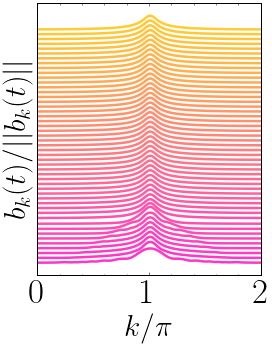

In [24]:
def get_joy_division_plot(nu):
    
    # Set parameters
    num_modes = nu
    Gammas = [1, 1, 1, 1][:num_modes]
    Gammas = np.array(Gammas)/np.sum(Gammas)
    kl_s = [0, np.pi/2, np.pi/3, np.pi/8][:num_modes]
    pump = 0.1
    g_c = 0
    l_k = 1000
    params = Gauss.create_params(Gammas, kl_s, pump, g_c, l_k)
    
    # Declare times
    Delta_PBC, Delta_OBC = Gauss.get_PBC_and_OBC_gaps(params)
    times = np.linspace(0, 10, 100)* (1/Delta_PBC)
    
    fig, ax = plt.subplots(figsize=(4,5))
    colors = plt.cm.spring(np.linspace(0.2, 0.8, 50))
    
    for (n, t) in enumerate(times):
        if  n<50 and t>0.1:
            
            b = dynamics(params, t, coherent_drive=True, init_state="homogeneous", save=False)
            b = b[:Gauss.N]
            
            ax.plot(np.linspace(0, 2, 100), np.abs(np.fft.fft(b))/np.linalg.norm(b) + 1*n, color=colors[n], linewidth=2.5)
            ax.set_xlabel('$k/\pi$', fontsize=30)
            ax.set_ylabel('$b_k(t)/||b_k(t)||$', fontsize=30)
            ax.set_xlim([0,2])
            ax.set_yticks([])
        
get_joy_division_plot(1)

### Topological features in the metastability regime

To illustrate the amplification dynamics, we calculate the time evolution of the total number of photons in the lattice, i.e., $N_\mathrm{ph}(t)=\sum_r|\langle b_r(t)\rangle|^2$, starting by an initially homogeneous situation, i.e., $\langle b_r(t=0)\rangle=1/N$, with $N$ being the number of lattice sites.

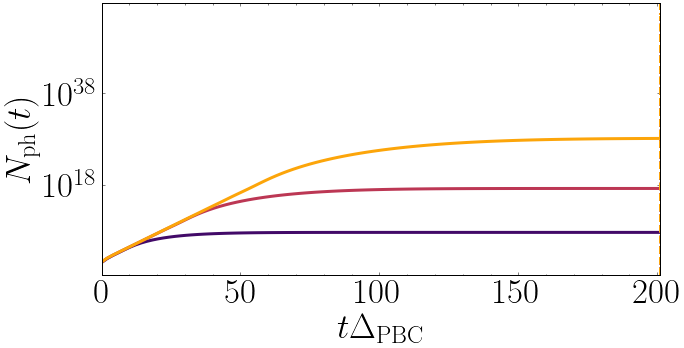

In [6]:
def plot_for_different_sizes():
    
    # Set parameters
    Gammas = [1, 1, 1]
    Gammas = np.array(Gammas)/np.sum(Gammas)
    kl_s = [0, np.pi/2, np.pi/3]
    pump = 0.7
    g_s = 0.
    l_k = 1000
    params = GaussianSystem(100).create_params(Gammas, kl_s, pump, g_s, l_k)
    
    # Declare times scales
    Delta_PBC, Delta_OBC = GaussianSystem(100).get_PBC_and_OBC_gaps(params)
    ts = (1/Delta_PBC)*np.linspace(0, 70, 100)
    delta_t = (np.max(ts)-np.min(ts))/len(ts)
    
    fig, ax = plt.subplots(figsize=(10,5))
    colors = plt.cm.inferno(np.linspace(0.2, 0.8, 3))
    
    for (i, N) in enumerate([5, 12, 20]):
    
        Gauss_aux = GaussianSystem(N)
        
        # Initialize array of norms
        b_norm = []
     
        # Evolve
        H_nh = Gauss_aux.get_H_nh(params)
        
        f = np.zeros(Gauss_aux.N)
        f[-1] = 1
        b_ss = Gauss_aux.get_steady_state_coherences(-1j*H_nh, f)
        
        U = sp.linalg.expm(-1j*H_nh*delta_t)
        b0 = np.ones((2*Gauss_aux.N))/N
        b = b0

        # Coefficients
        C = np.zeros((Gauss_aux.N, len(ts)))

        for t in ts:

            b = U @ (b - b_ss) + b_ss
            b_norm.append(np.linalg.norm(b)**2)
            
        ax.plot(ts, b_norm, color=colors[i], linewidth=3, label='$N=$'+str(N))
        index_max = np.argmax(b_norm)
        ax.axvline(ts[index_max], linestyle='dashed', linewidth=2, color=colors[i])
        
    ax.set_yscale('log')
    ax.set_xlim([ts[0], ts[-1]])
    ax.set_xlabel('$t\Delta_\\text{PBC}$', fontsize=35)
    ax.set_ylabel('$N_\\text{ph}(t)$', fontsize=35)
    ax.axhline(10**55, color='white')
    
plot_for_different_sizes()

Given the singular value decomposition of the dynamical matrix $\mathbb{H}=USV^\dagger$, the evolution operator can be written as
\begin{align}
e^{-i\mathbb{H}t}\mathbf{b}=\left(\mathbf{1}-i t U SV^\dagger-\frac{t^2}{2}U SV^\dagger U SV^\dagger+...\right)  \mathbf{b}\;,
\end{align}
the expansion contains the identity $\mathbf{1}$ and a series of terms all ending in $V^\dagger$. Then, $e^{-i\mathbb{H}t}\mathbf{b}$ is equal to $\mathbf{b}$ plus a term that is proportional to $V^\dagger\mathbf{b}$. Picking columns of $V$ associated to topological singular values leads to coherences vectors that evolve much slower than bulk ones.

/home/carlos/Desktop/Chiral_Multimode_Physics/GaussianSystem.py:358: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  nu = (1/(2*np.pi*1j))*integrate.quad(real_f, -np.pi, np.pi)[0]
/home/carlos/Desktop/Chiral_Multimode_Physics/GaussianSystem.py:359: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu += (1/(2*np.pi))*integrate.quad(imag_f, -np.pi, np.pi)[0]


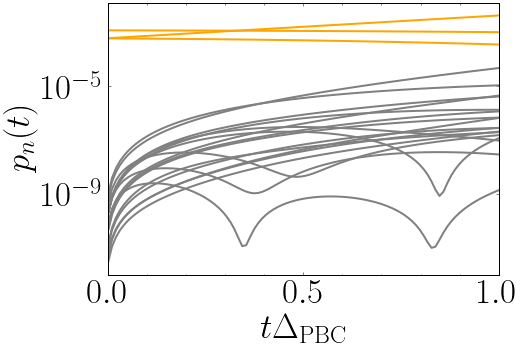

In [13]:

Gauss = GaussianSystem(20)

# Set parameters
Gammas = [1, 1, 1]
Gammas = np.array(Gammas)/np.sum(Gammas)
kl_s = [0, np.pi/2, np.pi/3]
pump = 0.7
g_s = 0.
l_k = 1000
params = Gauss.create_params(Gammas, kl_s, pump, g_s, l_k)


def coefficient_evolution(params, index):
    
    W = int(Gauss.compute_winding_scalar(params))
    A = 1j*params['pump']*np.eye(Gauss.N)/2 + Gauss.get_H_eff(params)
    U, s, V_dagger = np.linalg.svd(A)
    V = V_dagger.transpose().conjugate()
    
    # Declare times scales
    Delta_PBC, Delta_OBC = Gauss.get_PBC_and_OBC_gaps(params)
    ts = (1/Delta_PBC)*np.linspace(0, 1, 100)
    delta_t = (np.max(ts)-np.min(ts))/len(ts)
    
    # Evolve
    H_nh = Gauss.get_H_nh(params)
    
    f = np.zeros(Gauss.N)
    f[-1] = 1e-10
    b_ss = Gauss.get_steady_state_coherences(-1j*H_nh, f)
    
    U = sp.linalg.expm(-1j*H_nh*delta_t)
    b0 = np.concatenate(((1/np.sqrt(2))*V[:,-1]+0.5*V[:,-2]+0.5*V[:,-3],V[:,-1]))/Gauss.N
    b = b0
    
    # Coefficients
    C = np.zeros((Gauss.N, len(ts)))
    
    for (i, t) in enumerate(ts):
        
        b = U @ (b - b_ss) + b_ss
                 
        for n in range(Gauss.N):
                 
            C[n, i] = np.abs(np.dot(b[:Gauss.N].conjugate(), V[:,n]))**2
                 
    def set_color(n):
        if n<Gauss.N-W: return 'grey'
        else: return 'orange'
                 
    fig, ax = plt.subplots(figsize=(7,5))
    
    for n in range(Gauss.N):
        ax.plot(ts*Delta_PBC, C[n,:], linewidth=2, color=set_color(n))
    
    ax.set_xlabel('$t\Delta_\\text{PBC}$', fontsize=35)
    ax.set_ylabel('$p_n(t)$', fontsize=35)
    ax.set_xlim([np.min(ts)*Delta_PBC, np.max(ts)*Delta_PBC])
    #ax.axvline(1/s[-1], linewidth=2, linestyle='dashdot', color='black')
    ax.set_yscale('log')
    
coefficient_evolution(params, index=-1)
#plt.savefig('images/metastable_bulk.svg')

Finally, let us show the code for computing time-evolved coherence distributions in real space:

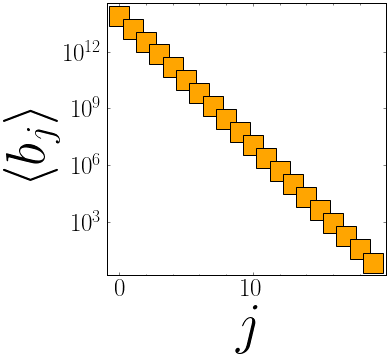

In [170]:
# Set parameters
Gauss = GaussianSystem(20)
Gammas = [1, 1, 1]
Gammas = np.array(Gammas)/np.sum(Gammas)
kl_s = [0, np.pi/2, np.pi/3]
pump = 0.7
g_s = 0.
l_k = 1000
params = Gauss.create_params(Gammas, kl_s, pump, g_s, l_k)

Delta_PBC, Delta_OBC = Gauss.get_PBC_and_OBC_gaps(params)
H_nh = Gauss.get_H_nh(params)
f = np.zeros(Gauss.N)
f[-1] = 1
b_ss = Gauss.get_steady_state_coherences(-1j*H_nh, f)

# Probe time
T_probe = 50
U = sp.linalg.expm(-1j*H_nh*T_probe)
b0 = np.ones((2*Gauss.N))/Gauss.N
b = U @ (b0 - b_ss) + b_ss

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(Gauss.N), np.abs(b[:Gauss.N]), 's', markersize = 20, mec='black',
           label='Exact', color='orange')
ax.set_xlabel('$j$', fontsize=55)
ax.set_ylabel('$\langle b_j \\rangle$', fontsize=55)
ax.set_yscale('log')
#plt.savefig('dynamics_3.svg')